In [1]:
from kubernetes import client, config
import json
import matplotlib.pyplot as plt
import numpy as np
from ortools.linear_solver import pywraplp
from palettable.colorbrewer.qualitative import Set2_7
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager


In [2]:
params = {
   'axes.labelsize': 16,
   'font.size': 14,
   'legend.fontsize': 18,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
   'figure.figsize': [7, 5],
   'hist.bins': 20,
}
rcParams = plt.rcParams
rcParams.update(params)
config.load_kube_config()
graph_dir = "graphs/"
cs = Set2_7.mpl_colors


# Consensus Stats

In [3]:
stats_name = ['msg rcv total',
              'msg sent total',
              'comp time per iter',
              'xchg time per iter',
              'avg time per iter',
              'total time',
              'total iter',
              'setup time']

In [3]:
def read_metrics():
    metrics = {}

    v1 = client.CoreV1Api()
    ret = v1.list_pod_for_all_namespaces(watch=False)
    for i in ret.items:
        if i.metadata.name.startswith("my-scheduler-") or i.metadata.name.startswith("my-controller"):
            # print(f"{i.metadata.name} {i.status.pod_ip}")
            lines = v1.read_namespaced_pod_log(
                name=i.metadata.name, namespace=i.metadata.namespace)

            name = i.metadata.name
            if name.startswith('my-scheduler-'):
                metrics[name] = {}
            for line in lines.split('\n'):
                if name.startswith('my-sched') and line.startswith('{'):
                    d = json.loads(line)
                    for sn in stats_name:
                        if sn.endswith('per iter'):
                            if not sn in metrics[name]:
                                metrics[name][sn] = []
                            if sn in d:
                                metrics[name][sn].append(d[sn])
                        else:
                            if sn in d:
                                metrics[name][sn] = d[sn]
    return metrics

## stats per pod

Plot stats, large variance in computation time per iteration is perhaps due to the
short period of computation leading to incorrect timing measurement

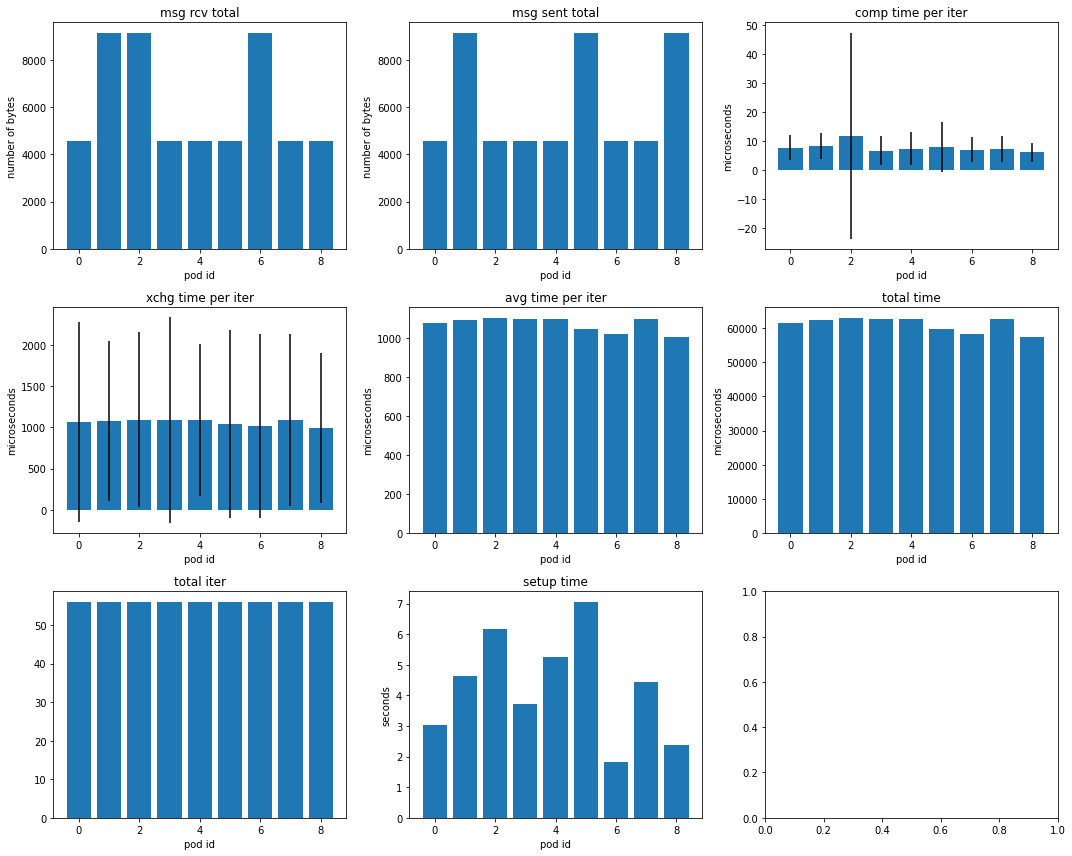

In [10]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 12)

x = range(len(metrics.keys()))


for i, sn in enumerate(stats_name):
    y = []
    a = ax[i // 3][i % 3]
    a.set_xlabel('pod id')
    if i in [0, 1]:
        a.set_ylabel('number of bytes')
    elif i in [2, 3, 4, 5]:
        a.set_ylabel("microseconds")

    if sn.find('total') != -1:
        for name in metrics:
            y.append(metrics[name][sn])
        a.bar(x, y)
        a.set_title(sn)

    elif sn.find('per iter') != -1:
        for name in metrics:
            d = np.array(metrics[name][sn])
            mean = np.mean(d)
            std = np.std(d)
            y.append([mean, std])
        y = np.array(y)
        a = ax[i // 3][i % 3]
        a.bar(x, y[:, 0], yerr = y[:, 1])
        a.set_title(sn)

    elif sn.find('setup time') != -1:
        for name in metrics:
            y.append(metrics[name]['fields.time'])
        a = ax[i // 3][i % 3]
        a.bar(x, y)
        a.set_title(sn)
        a.set_ylabel('seconds')


fig.tight_layout()
fig.savefig(f'{graph_dir}metrics-{p}pods.png')



## Stats against number of pods

In [7]:
dirs = [
  ['data/2022-10-10T20-25-54', 'data/2022-10-10T20-38-36', 'data/2022-10-10T20-21-42'],
  ['data/2022-10-10T20-59-24','data/2022-10-10T21-01-14', 'data/2022-10-10T21-16-25'],
  ['data/2022-10-10T21-22-36', 'data/2022-10-10T21-27-53', 'data/2022-10-10T21-33-11'],
  ['data/2022-10-10T21-40-09', 'data/2022-10-10T21-47-09', 'data/2022-10-10T21-54-10'],
  ['data/2022-10-10T22-02-51', 'data/2022-10-10T22-11-36', 'data/2022-10-10T22-20-22'],
  ['data/2022-10-10T22-30-48', 'data/2022-10-10T22-41-19', 'data/2022-10-10T22-51-48'],
  ['data/2022-10-10T23-03-56', 'data/2022-10-10T23-16-10', 'data/2022-10-10T23-28-23'],
  ['data/2022-10-10T23-42-15', 'data/2022-10-10T23-56-10', 'data/2022-10-11T00-10-06'],
  ['data/2022-10-11T10-57-18', 'data/2022-10-11T00-41-46', 'data/2022-10-11T00-57-25']
]

pods = range(100, len(dirs) * 100 + 100, 100)
y_msg = []
y_iter = []
y_setup = []

for i, pod in enumerate(pods):
  msgs = []
  iters = []
  setups = []
  for dir in dirs[i]:
    with open(f'{dir}/consensus-{pod}pods-1.0jobs.json', 'r') as f:
      data = json.load(f)

      msg = []
      iter = []
      setup = []

      for s, d in data['0'].items():
        msg.append(d['msg sent total'])
        iter.append(d['total iter'])
        setup.append(d['setup time'])

    msgs.append(sum(msg))
    if np.std(iter) > 0:
      print(iter)
    iters.append(np.mean(np.array(iter)))
    setups.append(np.mean(np.array(setup)))

    if (np.std(np.array(iter))) != 0:
      print(np.std(np.array(iter)))

  y_msg.append(msgs)
  y_iter.append(iters)
  y_setup.append(setups)


y_msg = np.array(y_msg)
y_iter = np.array(y_iter)
y_setup = np.array(y_setup)
y_msg_iter = np.array(y_msg) / np.array(y_iter)


y_msg = y_msg / 1e6
y_msg_iter = y_msg_iter / 1e6


# print(y_msg)
# print(np.median(y_msg, axis=1))
# print(y_iter)
print(y_setup)


[[ 26.39842654  26.95868114  26.95429748]
 [ 54.1714835   51.83418399  71.98030782]
 [ 94.82194197  94.75102252  60.8363411 ]
 [101.66488528  99.60516978  99.26526589]
 [108.47767271 110.93423007 111.54509251]
 [120.55642589 118.78132506 118.44015851]
 [125.87189225 199.40728148 194.942857  ]
 [202.5778425  205.67532504 205.09591204]
 [215.31791056 215.24533142 212.54593634]]


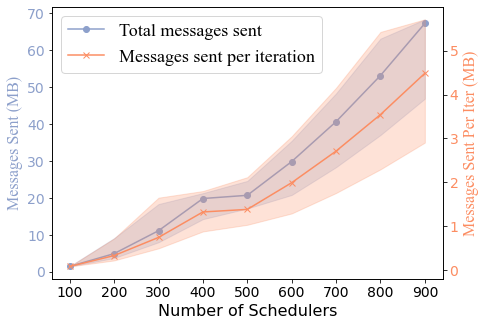

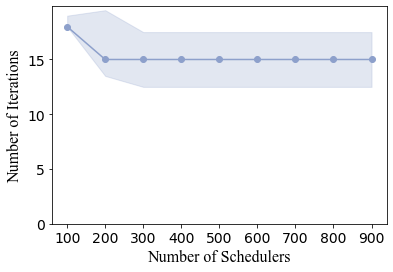

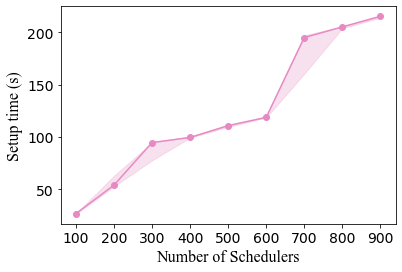

In [8]:
fig, ax1 = plt.subplots()



l1, = ax1.plot(pods, np.median(y_msg, axis = 1), marker='o', color=cs[2])
ax1.fill_between(pods, np.percentile(y_msg, 25, axis=1), np.percentile(y_msg, 75, axis=1), alpha=0.25, color=cs[2])
ax1.set_ylabel("Messages Sent (MB)", color=cs[2], fontname="Times New Roman")
ax1.tick_params(axis='y', labelcolor=cs[2])

ax2 = ax1.twinx()
l2, = ax2.plot(pods, np.median(y_msg_iter, axis=1), marker='x', color=cs[1])
ax2.fill_between(pods, np.percentile(y_msg_iter, 25, axis=1), np.percentile(y_msg_iter, 75, axis=1), alpha=0.25, color=cs[1])
ax2.set_ylabel("Messages Sent Per Iter (MB)", color=cs[1], fontname="Times New Roman")
ax2.tick_params(axis='y', labelcolor=cs[1])

ax1.set_xticks(pods)
ax1.set_xlabel("Number of Schedulers")

ax1.legend([l1, l2], ['Total messages sent', 'Messages sent per iteration'], loc='upper left', prop={'family':'Times New Roman'})


fig.set_size_inches(7, 5)
fig.savefig(f'{graph_dir}msg.pdf')

# fig, ax = plt.subplots()
# ax.plot(pods, np.median(y_msg_iter, axis=1), marker='o', color=cs[1])
# ax.fill_between(pods, np.percentile(y_msg_iter, 25, axis=1), np.percentile(y_msg_iter, 75, axis=1), alpha=0.25, color=cs[1])
# ax.set_ylabel("Messages per iteration")
# ax.set_xlabel("number of schedulers")


# fig.savefig(f'{graph_dir}msg_per_iter.png')


fig, ax = plt.subplots()
ax.plot(pods, np.median(y_iter, axis=1), marker='o', color=cs[2])
ax.fill_between(pods, np.percentile(y_iter, 25, axis=1), np.percentile(y_iter, 75, axis=1), alpha=0.25, color=cs[2])
ax.set_ylabel('Number of Iterations', fontname="Times New Roman")
ax.set_xlabel('Number of Schedulers', fontname="Times New Roman")
ax.set_xticks(pods)
ax.set_ylim(bottom=0)


fig.savefig(f'{graph_dir}iter.pdf')


fig, ax = plt.subplots()
ax.plot(pods, np.median(y_setup, axis=1), marker='o', color=cs[3])
ax.fill_between(pods, np.percentile(y_setup, 25, axis=1), np.percentile(y_setup, 75, axis=1), alpha=0.25, color=cs[3])
ax.set_ylabel('Setup time (s)', fontname="Times New Roman")
ax.set_xlabel('Number of Schedulers', fontname="Times New Roman")

ax.set_xticks(pods)

fig.savefig(f'{graph_dir}setup.pdf')


In [3]:
# dirs = ['data/2022-08-15T']
metrics = {}
pods = range(100, 1000, 100)
runs = range(11)
for p in pods:
  with open(f'old_data/data-{p}pods.json', 'r') as f:
    for line in f:
      metrics[p] = json.loads(line)
print(metrics[100]['0']['my-scheduler-c5648b7d-22lrq']['setup time'])

29.934439289


[25.285673272390003, 48.193742211495, 59.537336736096655, 103.29436982058749, 108.52537372822398, 113.11784029334832, 199.8603418205943, 206.77935047405626, 218.80870471536667]


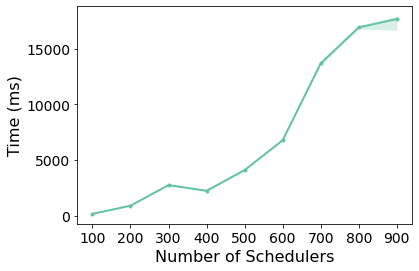

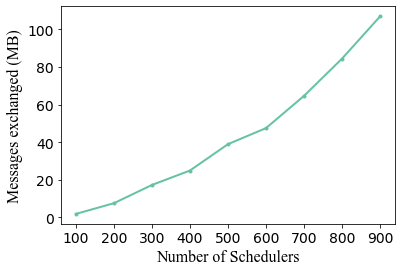

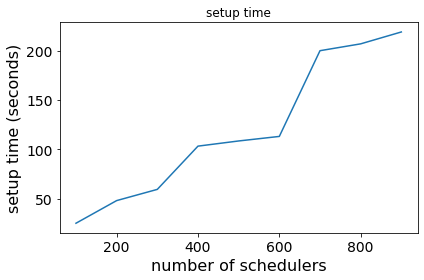

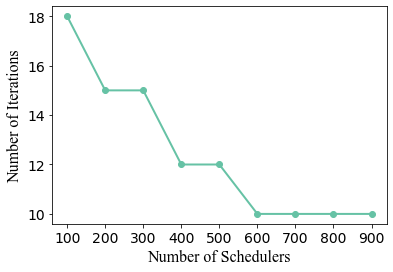

In [4]:

x = pods
y_time = []
y_msg_sent = []
y_setup = []
y_iter = []

for p in pods:
  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['total time'] for name in metrics[p][r]])
  t1.append(np.mean(t2))

  y_time.append([np.median(t2), np.percentile(t2, 25), np.percentile(t2, 75)])

  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['msg sent total'] for name in metrics[p][r]])
  t1.append(np.sum(t2))
  y_msg_sent.append([np.mean(t1), np.std(t1)])

  t2 = np.array([metrics[p]['0'][name]['setup time'] for name in metrics[p][r]])
  y_setup.append(np.mean(t2))


  t2 = np.array([metrics[p]['0'][name]['total iter'] for name in metrics[p][r]])
  y_iter.append(np.mean(t2))


  
y_time = np.array(y_time) / 1000
y_msg_sent = np.array(y_msg_sent) / 1e6




# -------- latency --------- #

fig, ax = plt.subplots()
ax.plot(x, y_time[:, 0], color=cs[0], linewidth=2, marker='.')
ax.fill_between(x, y_time[:, 1], y_time[:, 2], color=cs[0], linewidth=0, alpha=0.25)
# ax.set_title('total consensus time (excluding setup)')
ax.set_xlabel('Number of Schedulers')
ax.set_ylabel('Time (ms)')
ax.set_xticks(x)

fig.savefig(f'{graph_dir}con_latency.pdf')


# -------- msg sent --------- #

fig, ax = plt.subplots()
ax.plot(x, y_msg_sent[:, 0], color=cs[0], linewidth=2, marker='.')
ax.set_xlabel('Number of Schedulers', fontname='Times New Roman')
ax.set_ylabel('Messages exchanged (MB)', fontname='Times New Roman')
ax.set_xticks(x)

fig.savefig(f'{graph_dir}message.pdf')


# -------- setup time --------- #

fig, ax = plt.subplots()
ax.plot(x, y_setup)
ax.set_title('setup time')
ax.set_xlabel('number of schedulers')
ax.set_ylabel('setup time (seconds)')
fig.tight_layout()
fig.savefig(f'{graph_dir}setup_time.png')


#------ iteration -------- #
fig, ax = plt.subplots()
ax.plot(x, y_iter, color=cs[0], linewidth=2, marker='o')
ax.set_xlabel('Number of Schedulers', fontname='Times New Roman')
ax.set_ylabel('Number of Iterations', fontname='Times New Roman')
ax.set_xticks(x)

fig.savefig(f'{graph_dir}iter.pdf')


print(y_setup)


## CPU and Memory

In [3]:
cpu = np.array([
  [1.11,3.41,7.11,12.1,17.9,22.0,25.5,31.5,39.2],
  [1.02,3.43,7.37,12.0,17.9,21.9,29.0,30.2,38.8],
  [1.61,3.41,7.12,11.9,17.7,23.0,25.4,32.5,40.7],
  [1.65,3.47,7.28,11.7,17.1,21.8,29.1,33.3,40.8]
])

np.median(cpu, axis=0)
np.percentile(cpu, 25, axis=0)

array([ 1.0875,  3.41  ,  7.1175, 11.85  , 17.55  , 21.875 , 25.475 ,
       31.175 , 39.1   ])

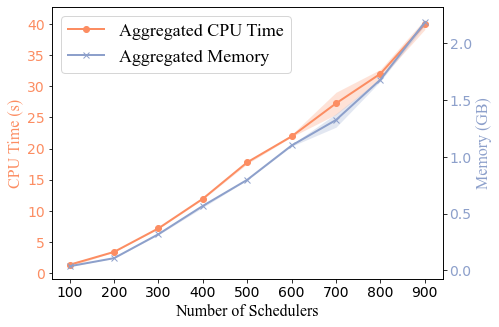

In [6]:
# cpu = [0.17, 0.455, 1.438, 2.908, 4.347, 5.454]
# mem = [5.97, 11.55, 19.87, 31.54, 43.16, 57.71]

cpu = np.array([
  [1.11,3.41,7.11,12.1,17.9,22.0,25.5,31.5,39.2],
  [1.02,3.43,7.37,12.0,17.9,21.9,29.0,30.2,38.8],
  [1.61,3.41,7.12,11.9,17.7,23.0,25.4,32.5,40.7],
  [1.65,3.47,7.28,11.7,17.1,21.8,29.1,33.3,40.8]
])

mem = np.array([
  [37.5,107,330,520,798,1092,1274,1674,2209],
  [37.8,108,314,571,798,1094,1375,1637,2157],
  [30.0,112,315,566,794,1117,1222,1685,2212],
  [38.2,109,324,584,800,1106,1394,1700,2158]
])


mem = np.array(mem) / 1000


pods = [i * 100 for i in range(1, len(cpu[0]) + 1)]

fig, ax2 = plt.subplots()
fig.set_size_inches(7, 5)

ax1=ax2.twinx()

l1, = ax2.plot(pods, np.median(cpu, axis=0), color=cs[1], linewidth=2, marker='o')
ax2.fill_between(pods, np.percentile(cpu, 25, axis=0), np.percentile(cpu, 75, axis=0), color=cs[1], linewidth=0, alpha=0.25)
ax2.set_ylabel('CPU Time (s)', color=cs[1], fontname='Times New Roman')
ax2.tick_params(axis='y', labelcolor=cs[1])

l2, = ax1.plot(pods, np.median(mem, axis=0), color=cs[2], linewidth=2, marker='x')
ax1.fill_between(pods, np.percentile(mem, 25, axis=0), np.percentile(mem, 75, axis=0), color=cs[2], linewidth=0, alpha=0.25)
ax1.set_ylabel('Memory (GB)', color=cs[2], fontname='Times New Roman')
ax1.tick_params(axis='y', labelcolor=cs[2])

ax2.set_xticks(pods)
ax2.set_xlabel('Number of Schedulers', fontname='Times New Roman')

ax1.legend([l1, l2], ['Aggregated CPU Time', 'Aggregated Memory'], loc='upper left', prop={'family':'Times New Roman'})

fig.savefig(f'{graph_dir}cpu-and-memory-usage.pdf')

# Placement Stats

## Capacity left

### Multiple-Knapsck

In [9]:
def mk_solve(weights, capacity):
    data = {}
    data['weights'] = weights
    data['values'] = [
        1 for _ in range(len(weights))
    ]
    assert len(data['weights']) == len(data['values'])
    data['num_items'] = len(data['weights'])
    data['all_items'] = range(data['num_items'])

    data['bin_capacities'] = capacity
    data['num_bins'] = len(data['bin_capacities'])
    data['all_bins'] = range(data['num_bins'])

    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if solver is None:
        print('SCIP solver unavailable.')
        return

    # Variables.
    # x[i, b] = 1 if item i is packed in bin b.
    x = {}
    for i in data['all_items']:
        for b in data['all_bins']:
            x[i, b] = solver.BoolVar(f'x_{i}_{b}')

    # Constraints.
    # Each item is assigned to at most one bin.
    for i in data['all_items']:
        solver.Add(sum(x[i, b] for b in data['all_bins']) <= 1)

    # The amount packed in each bin cannot exceed its capacity.
    for b in data['all_bins']:
        solver.Add(
            sum(x[i, b] * data['weights'][i]
                for i in data['all_items']) <= data['bin_capacities'][b])

    # Objective.
    # Maximize total value of packed items.
    objective = solver.Objective()
    for i in data['all_items']:
        for b in data['all_bins']:
            objective.SetCoefficient(x[i, b], data['values'][i])
    objective.SetMaximization()

    status = solver.Solve()

    scheduled = []
    if status == pywraplp.Solver.OPTIMAL:
        # print(f'Total packed value: {objective.Value()}')
        total_weight = 0
        for b in data['all_bins']:
            # print(f'Bin {b}')
            bin_weight = 0
            bin_value = 0
            for i in data['all_items']:
                if x[i, b].solution_value() > 0:
                    # print(
                    #     f"Item {i} weight: {data['weights'][i]} value: {data['values'][i]}"
                    # )
                    scheduled.append(data['weights'][i])
                    bin_weight += data['weights'][i]
                    bin_value += data['values'][i]
            # print(f'Packed bin weight: {bin_weight}')
            # print(f'Packed bin value: {bin_value}\n')
            total_weight += bin_weight
        # print(f'Total packed weight: {total_weight}')
    else:
        print('The problem does not have an optimal solution.')
    return scheduled

### Actual plot

In [8]:


# --- gaussian with jobs --- #
dirs = ['data/2022-08-16T13-41-06', 'data/2022-08-16T13-50-14', 'data/2022-08-16T13-53-15', 'data/2022-08-16T14-00-30']

# --- gaussian with scheduled jobs --- #
dirs = ['data/2022-08-16T17-03-38', 'data/2022-08-16T17-07-26', 'data/2022-08-16T17-12-57', 'data/2022-08-16T17-20-12']

# --- poisson --- #
dirs = ['data/2022-08-18T12-44-03', 'data/2022-08-18T12-47-39', 'data/2022-08-18T12-51-15', 'data/2022-08-18T12-54-52', 'data/2022-08-18T12-58-28']

# --- posisson2 --- #
dirs = ['data/2022-08-18T14-54-43', 'data/2022-08-18T15-00-33', 'data/2022-08-18T15-21-50', 'data/2022-08-18T15-25-27', 'data/2022-08-18T15-29-02']

# --- poisson random queue choice --- #
dirs = ['data/2022-08-18T16-58-58', 'data/2022-08-18T16-59-48', 'data/2022-08-18T17-00-50']

# --- poisson smaller mean --- #
dirs = ['data/2022-08-19T16-29-17', 'data/2022-08-19T16-30-29', 'data/2022-08-19T16-31-27', 'data/2022-08-19T16-59-55']

# --- skew normal --- #
dirs = ['data/2022-08-24T11-02-03', 'data/2022-08-24T11-04-03', 'data/2022-08-24T11-06-01', 'data/2022-08-24T11-10-18']




#--- gaussian distribtuion --- #
dirs = ['data/2022-08-16T11-19-32', 'data/2022-08-16T11-23-20', 'data/2022-08-16T11-27-08', 'data/2022-08-16T11-31-12']


#--- uniform distribution --- #
dirs = ['data/2022-08-11T18-01-42/', 'data/2022-08-11T18-06-46/', 'data/2022-08-11T18-12-00/', 'data/2022-08-11T18-18-56/']


# --- skew normal 2 --- #
dirs = ['data/2022-08-24T14-15-46','data/2022-08-24T14-26-34', 'data/2022-08-24T14-28-18', 'data/2022-08-24T14-32-10']




In [9]:
pl = [{} for _ in range(len(dirs))]
jobs = [0.5, 1.0, 2.0, 3.0, 4.0]
pods = [(i+1) * 100 for i in range(len(dirs))]
runs = range(10)
for i, dir in enumerate(dirs):
  with open(f'{dir}/placement-{100}pods-{jobs[i]}jobs.json', 'r') as f:
  # with open(f'{dir}/placement-{pods[i]}pods-60cap-2c.json', 'r') as f:
    for l in f:
      pl[i] = json.loads(l)

In [10]:
initial_ws = []
final_ws = []
left_elements = []
sched_elements = []
generated_jobs = []
sched_pcts = []
for i in range(len(dirs)):
  initial_w = []
  final_w = []
  for k, v in pl[i]['0'].items():
    if k == 'my-controller':
      left_elements.append(np.array(v['left elements']))
      sched_elements.append(v['scheduled elements'])
      generated_jobs.append(v['generated jobs'])
    else:
      initial_w.append(v['initial w'])
      final_w.append(v['final w'])

  initial_ws.append(np.array(initial_w))
  final_ws.append(np.array(final_w))

  sched_pct = []
  for r in runs:
    for k, v in pl[i][str(r)].items():
      if k == 'my-controller':
        sched_pct.append(len(v['scheduled elements']) / len(v['generated jobs']))
  sched_pct = np.array(sched_pct)
  sched_pcts.append([np.mean(sched_pct), np.std(sched_pct)])

sched_pcts = np.array(sched_pcts)

# print(final_ws)
# print(f'sum is {np.sum(final_w)}')
# print(f'mean is {np.mean(final_w)}')
# print(f'std is {np.std(final_w)}')
# print(f'elements left are {left_elements}')



In [11]:
opt_sched = []

for i in range(2):
  opt_sched.append(mk_solve(generated_jobs[i], initial_ws[i]))


NameError: name 'mk_solve' is not defined

initial w is 11.811439914465797


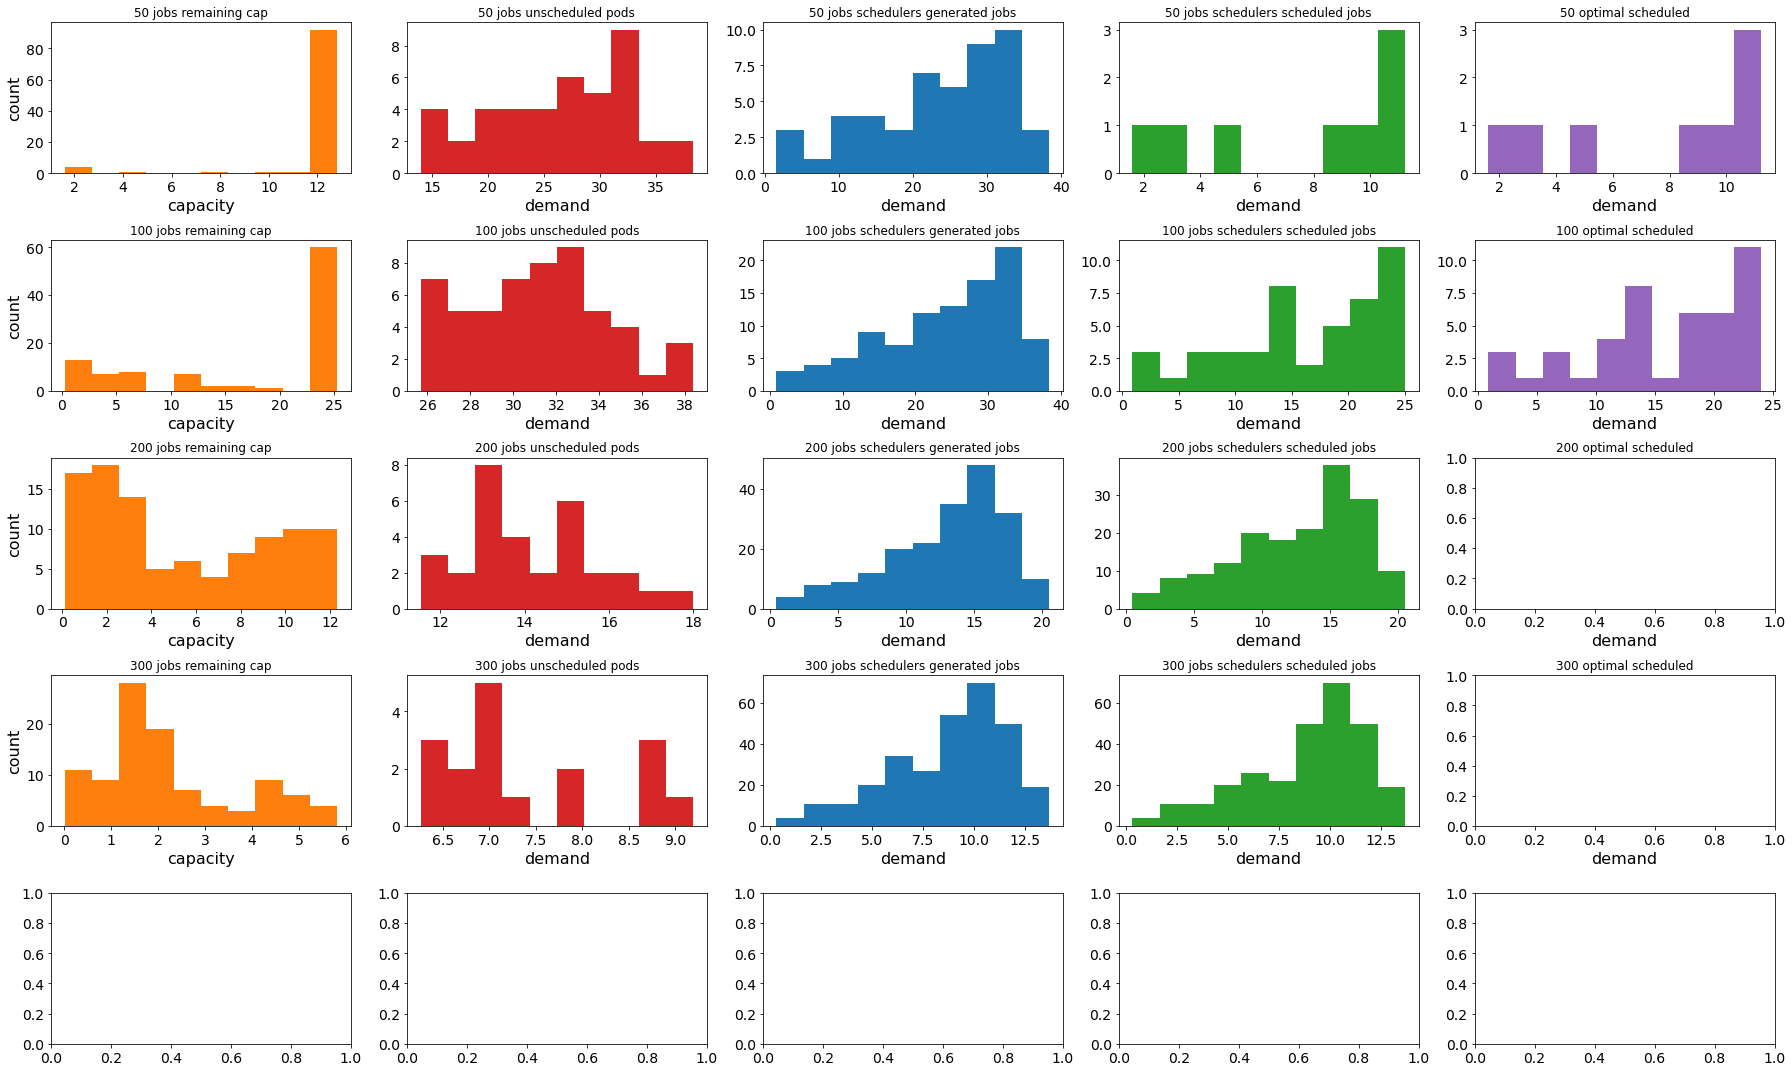

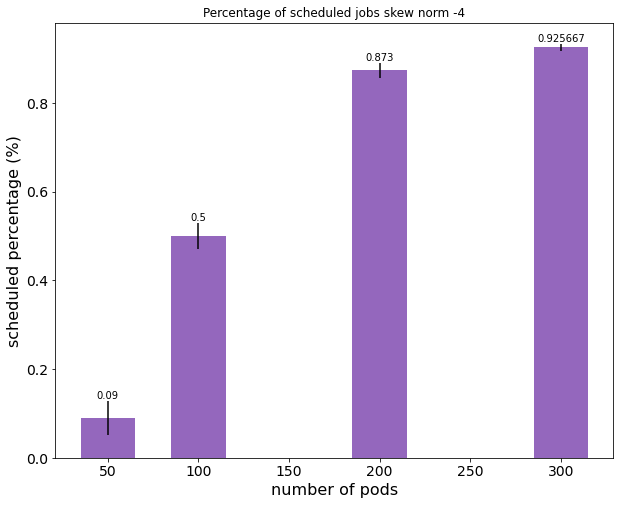

In [14]:
fig, ax = plt.subplots(5, ncols=5)
fig.set_size_inches(25, 15)

print(f'initial w is {initial_ws[0][0]}')
for i in range(len(dirs)):
  ax[i][0].hist(final_ws[i], color='tab:orange')
  ax[i][1].hist(left_elements[i], color='tab:red')
  ax[i][2].hist(generated_jobs[i], color='tab:blue')
  ax[i][3].hist(sched_elements[i], color='tab:green')

  if i < 2:
    ax[i][4].hist(opt_sched[i], color='tab:purple')

  ax[i][0].set_title(f'{int(100 * jobs[i])} jobs remaining cap')
  ax[i][1].set_title(f'{int(100 * jobs[i])} jobs unscheduled pods')
  ax[i][2].set_title(f'{int(100 * jobs[i])} jobs schedulers generated jobs')
  ax[i][3].set_title(f'{int(100 * jobs[i])} jobs schedulers scheduled jobs')
  ax[i][4].set_title(f'{int(100 * jobs[i])} optimal scheduled')


  ax[i][0].set_xlabel('capacity')
  ax[i][1].set_xlabel('demand')
  ax[i][2].set_xlabel('demand')
  ax[i][3].set_xlabel('demand')
  ax[i][4].set_xlabel('demand')


  ax[i][0].set_ylabel('count')
  # ax.axhline(sl)

fig.tight_layout()


fig.savefig(f'{graph_dir}skew-norm-job-distribution.png')

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
b = ax.bar([jobs[i] * 100 for i in range(len(dirs))], sched_pcts[:, 0], width=30, yerr=sched_pcts[:, 1], color='tab:purple')
ax.bar_label(b, label_type='edge')
ax.set_title('Percentage of scheduled jobs skew norm -4')
ax.set_xlabel('number of pods')
ax.set_ylabel('scheduled percentage (%)')


fig.savefig(f'{graph_dir}skew-norm-schedpct.png')

initial w is 11.811439914465797


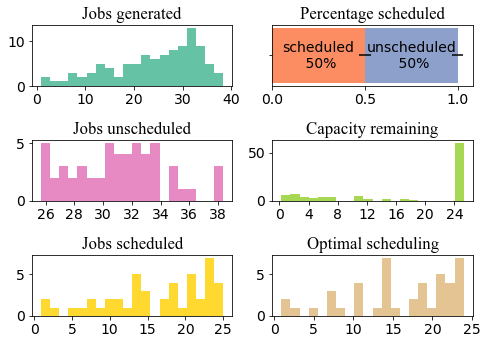

In [51]:
fig, ax = plt.subplots(nrows = 3, ncols=2)

print(f'initial w is {initial_ws[0][0]}')

ax[0][0].hist(generated_jobs[1], color=cs[0])

p1=ax[0][1].barh([0], sched_pcts[1, 0], xerr=sched_pcts[1, 1], color=cs[1], label='scheduled')
p2=ax[0][1].barh([0], 1-sched_pcts[1, 0], xerr=sched_pcts[1, 1], color=cs[2], left=sched_pcts[1, 0], label='unscheduled')
ax[0][1].set_yticks([0], [''])
ax[0][1].bar_label(p1, label_type='center', labels=['scheduled\n 50%'])
ax[0][1].bar_label(p2, label_type='center', labels=['unscheduled\n 50%'])

ax[1][0].hist(left_elements[1], color=cs[3])
ax[1][1].hist(final_ws[1], color=cs[4])
ax[2][0].hist(sched_elements[1], color=cs[5])
ax[2][1].hist(opt_sched[1], color=cs[6])


ax[0][0].xaxis.set_major_locator(ticker.MultipleLocator(10))
ax[1][0].xaxis.set_major_locator(ticker.MultipleLocator(2))
ax[1][1].xaxis.set_major_locator(ticker.MultipleLocator(4))
ax[2][0].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[2][1].xaxis.set_major_locator(ticker.MultipleLocator(5))


ax[0][0].set_title(f'Jobs generated', fontname='Times New Roman')
ax[0][1].set_title(f'Percentage scheduled', fontname='Times New Roman')
ax[1][0].set_title(f'Jobs unscheduled', fontname='Times New Roman')
ax[1][1].set_title(f'Capacity remaining', fontname='Times New Roman')
ax[2][0].set_title(f'Jobs scheduled', fontname='Times New Roman')
ax[2][1].set_title(f'Optimal scheduling', fontname='Times New Roman')


  # ax[i][0].set_xlabel('capacity')
  # ax[i][1].set_xlabel('demand')
  # ax[i][2].set_xlabel('demand')
  # ax[i][3].set_xlabel('demand')
  # ax[i][4].set_xlabel('demand')


  # ax[i][0].set_ylabel('count')
  # ax.axhline(sl)

fig.tight_layout()
fig.savefig(f'{graph_dir}skew-norm-job-distribution.pdf')


## Time taken

In [9]:
# dirs = ['data/2022-08-15T14-59-24', 'data/2022-08-15T15-02-56', 'data/2022-08-15T15-08-12',
#   'data/2022-08-15T15-15-12', 'data/2022-08-15T15-46-44', 'data/2022-08-15T15-51-43']
# ---- uniform distribtuion ---- #
# dirs = ['data/2022-08-15T16-00-21', 'data/2022-08-15T16-04-29', 'data/2022-08-15T16-06-44',
#   'data/2022-08-15T16-10-19', 'data/2022-08-15T16-16-32']
# ---- gaussian distribution ---- #
dirs = ['data/2022-08-16T11-19-32', 'data/2022-08-16T11-23-20', 'data/2022-08-16T11-27-08','data/2022-08-16T11-31-12']

# ---- gaussian distribution neo ---- #

dirs = ['data/2022-10-03T22-25-22', 'data/2022-10-03T22-27-09', 'data/2022-10-03T22-29-34', 'data/2022-10-03T22-32-53', \
  'data/2022-10-03T22-36-56', 'data/2022-10-03T22-43-39', 'data/2022-10-03T22-50-15', 'data/2022-10-03T23-00-24',\
  'data/2022-10-04T16-01-35']

pods = range(100, (len(dirs) + 1) * 100, 100)

metrics = {}
runs = range(10)

for i, dir in enumerate(dirs):
  with open(f'{dir}/consensus-{pods[i]}pods-1.0jobs.json', 'r') as f:
    for line in f:
      metrics[pods[i]] = json.loads(line)
x = pods
y_time = []
y_setup = []

for p in pods:
  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['total time'] for name in metrics[p][r]])
    t1.append(np.mean(t2))
  # print(t1, np.std(t1))
  y_time.append([np.median(t1), np.percentile(t1, 25), np.percentile(t1, 75)])

  t2 = np.array([metrics[p]['0'][name]['setup time'] for name in metrics[p][r]])
  y_setup.append(np.mean(t2))


y_time = np.array(y_time)


pl_times = []
# jobs_size = []
for i, dir in enumerate(dirs):
  with open(f'{dir}/placement-{pods[i]}pods-1.0jobs.json', 'r') as f:
    for l in f:
      pl = json.loads(l)
      ts = []
      js = []
      for j in runs:
        for k in pl[str(j)]:
          if k.startswith('my-controller'):
            ts.append(pl[str(j)][k]['time taken'])
      ts = np.array(ts)
      js = np.array(js)
      print(ts)
      pl_times.append([np.median(ts), np.percentile(ts, 25), np.percentile(ts, 75)])

pl_times = np.array(pl_times) / 1e6
y_time = np.array(y_time) / 1e6


# total_times = y_time + pl_times
# jobs_size = np.array(jobs_size)

print(pl_times)

[12968 12443 14978 15725 20458 12833 12374 13098 10994 10545]
[23674 25860 30449 22060 25744 21487 24679 26044 26423 27066]
[ 58419  33122 227366  35788  36294  35216  38342  33347  46062  56965]
[56844 64204 40672 48769 41896 44924 53680 42349 41103 44784]
[ 63767  50605 224018  50417  61662  59661  47748  46714  45447  51436]
[ 71629  64510  62593  57365  65485  58687 279729  95023  65031  83800]
[75735 83827 69731 79701 72913 67072 71391 73299 79097 93549]
[ 89152 123429 248565 117221  78680 104575 116421 268096  78666  75295]
[245901  91520 317490 235441  91834 235126 110644 284043 100233 129651]
[[0.0129005  0.01239125 0.014508  ]
 [0.025802   0.02392525 0.02632825]
 [0.037318   0.035359   0.05423925]
 [0.044854   0.04200925 0.05245225]
 [0.0510205  0.04841525 0.06116175]
 [0.065258   0.06307225 0.08075725]
 [0.074517   0.0717715  0.07955   ]
 [0.110498   0.081298   0.121877  ]
 [0.1823885  0.10283575 0.243286  ]]


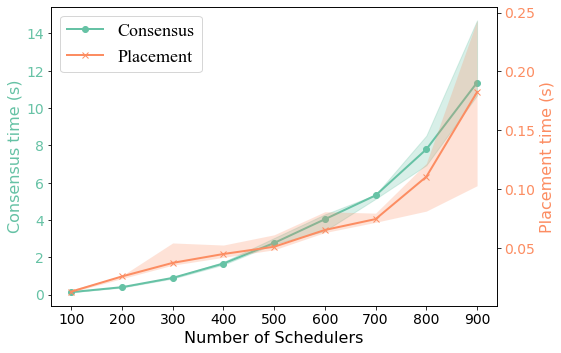

In [11]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8, 5.5)


l1, =ax1.plot(x, y_time[:, 0], label='consensus', color=cs[0], marker='o', linewidth=2)
ax1.fill_between(x, y_time[:, 1], y_time[:, 2], alpha=0.25, color=cs[0])
ax1.set_ylabel('Consensus time (s)', color=cs[0])
ax1.tick_params(axis='y', labelcolor=cs[0])

ax2 = ax1.twinx()
l2,=ax2.plot(pods, pl_times[:,0], marker='x', linewidth=2, color=cs[1], label='placement')
ax2.fill_between(pods, pl_times[:,1], pl_times[:,2], alpha=0.25, linewidth=0, color=cs[1])
ax2.set_ylabel('Placement time (s)', color=cs[1])
ax2.tick_params(axis='y', labelcolor=cs[1])

ax1.legend([l1, l2], ['Consensus', 'Placement'], loc='upper left', prop={'family':'Times New Roman'})


# ax2.plot(pods, y_time[:, 0], color=cs[0], linewidth=2, marker='.', label='consensus')
# ax2.fill_between(pods, y_time[:, 1], y_time[:, 2], color=cs[0], linewidth=0, alpha=0.25)
# ax2.set_ylabel('Consensus time (ms)', color=cs[0])
# ax2.tick_params(axis='y', labelcolor=cs[0])

# ax1 = ax2.twinx()
# ax1.plot(pods, pl_times[:,0], marker='.', linewidth=2, color=cs[1], label='placement')
# ax1.fill_between(pods, pl_times[:,1], pl_times[:,2], alpha=0.25, linewidth=0, color=cs[1])
# ax1.set_ylabel('Placement time (ms)', color=cs[1])
# ax1.tick_params(axis='y', labelcolor=cs[1])

# # ax.set_title('total consensus time (excluding setup)')
# ax.set_xlabel('Number of Schedulers')
# ax.set_ylabel('Time (ms)')
# ax.set_xticks(x)


ax1.set_xlabel('Number of Schedulers')

ax1.set_xticks(pods)
fig.savefig(f'{graph_dir}con-placement-latency.pdf')

# ax[2].bar(x, jobs_size[:, 0], width= 50,yerr = jobs_size[:, 1])
# ax[2].set_ylabel("number of jobs")
# ax[2].set_title("number of jobs")
# ax[2].set_xlabel('number of schedulers')

# fig.savefig(f'{graph_dir}latency-against-schedulers.png')

## Against number of jobs

In [3]:
# ---- normal distribution ---- #
# dirs = [
#   # ---- 100 pods ---- #
#   ['data/2022-08-17T14-16-14', 'data/2022-08-17T14-19-24', 'data/2022-08-17T14-21-41', 'data/2022-08-17T14-25-30', 'data/2022-08-17T14-29-30'],
#   # ---- 200 pods ---- #
#   ['data/2022-08-17T14-37-57', 'data/2022-08-17T14-41-36', 'data/2022-08-17T14-45-15', 'data/2022-08-17T14-48-53', 'data/2022-08-17T14-52-32'],
#   # ---- 300 pods ---- #
#   ['data/2022-08-17T15-06-07', 'data/2022-08-17T15-11-31', 'data/2022-08-17T15-16-55', 'data/2022-08-17T15-19-33', 'data/2022-08-17T15-22-35'],
#   # ---- 400 pods ---- #
#   ['data/2022-08-17T15-33-05', 'data/2022-08-17T15-36-44', 'data/2022-08-17T15-43-53', 'data/2022-08-17T15-51-03', 'data/2022-08-17T15-54-43']
# ]

# ---- poisson distribution ---- #
# dirs = [
#   # ---- 100 pods ---- #
#   ['data/2022-08-19T16-29-17', 'data/2022-08-19T16-30-29', 'data/2022-08-19T16-31-27', 'data/2022-08-19T16-59-55'],
#   # ---- 200 pods ---- #
#   ['data/2022-08-19T17-11-38', 'data/2022-08-19T17-14-38', 'data/2022-08-19T17-16-54', 'data/2022-08-19T17-20-29'],
#   ['data/2022-08-19T17-25-27', 'data/2022-08-19T17-28-44', 'data/2022-08-19T17-34-12', 'data/2022-08-19T17-39-40']
# ]

# ---- skew normal distribution ---- #
# dirs = [
#   # ---- 100 pods ---- #
#   ['data/2022-08-22T16-11-02', 'data/2022-08-22T16-12-13', 'data/2022-08-22T16-15-49', 'data/2022-08-22T16-19-25'],
#   # ---- 200 pods ---- #
#   ['data/2022-08-22T15-38-13', 'data/2022-08-22T15-40-19', 'data/2022-08-22T15-51-25', 'data/2022-08-22T15-55-33']
# ]

# ---- variance finding ---- #
dirs = [

  # ['data/2022-08-23T16-53-17', 'data/2022-08-23T16-56-58', 'data/2022-08-23T16-59-38', 'data/2022-08-23T17-03-03'],
  # ['data/2022-08-23T17-06-24', 'data/2022-08-23T17-09-32', 'data/2022-08-23T17-12-44', 'data/2022-08-23T17-16-32'],
  # ['data/2022-08-23T17-23-35', 'data/2022-08-23T17-29-15', 'data/2022-08-23T17-36-11', 'data/2022-08-23T17-43-05']

  # --- good results --- #
  ['data/2022-08-24T11-02-03', 'data/2022-08-24T11-04-03', 'data/2022-08-24T11-06-01', 'data/2022-08-24T11-10-18'],
  ['data/2022-08-24T11-14-03', 'data/2022-08-24T11-16-53', 'data/2022-08-24T11-19-55', 'data/2022-08-24T11-24-33'],
  ['data/2022-08-24T11-38-20', 'data/2022-08-24T11-43-03', 'data/2022-08-24T11-47-56', 'data/2022-08-24T11-51-53']
]

# ---- skew norm ---- #
# dirs = [
#   ['data/2022-08-24T14-15-46','data/2022-08-24T14-26-34', 'data/2022-08-24T14-28-18', 'data/2022-08-24T14-32-10'],
#   ['data/2022-08-24T14-37-32', 'data/2022-08-24T14-39-34', 'data/2022-08-24T14-41-33', 'data/2022-08-24T14-43-36'],
#   ['data/2022-08-24T15-58-32', 'data/2022-08-24T15-44-03', 'data/2022-08-24T15-46-49', 'data/2022-08-24T15-52-25']
# ]


pods = range(100, (len(dirs)+1) * 100, 100)
jf = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

total_pod_times = []
con_pod_times = []
pl_pod_times = []
sched_pod_pcts = []
pod_jobs = []


for pidx, p in enumerate(pods):
  jobs = [jf[i] * p for i in range(len(dirs[pidx]))]
  pod_jobs.append(jobs)

  metrics = {}
  runs = range(10)


  total_times = []
  con_times = []
  pl_times = []
  sched_pcts = []

  for i, dir in enumerate(dirs[pidx]):
    t1 = []
    with open(f'{dir}/consensus-{p}pods-{jf[i]}jobs.json', 'r') as f:
      con = json.loads(f.readline())
      for r in runs:
        r = str(r)
        t2 = np.array([con[r][name]['total time'] for name in con[r]])
        # if p == 200 and i == 3 and (r == '5' or r == '6'):
        #   print(t2)
        #   print(np.mean(t2))
        t1.append(np.mean(t2))
      t1 = t1[0:]
      # if p == 100:
      #   print(t1)
      #   print(np.mean(t1), np.std(t1))
      con_times.append([np.mean(t1), np.std(t1)])

    t2 = []
    sched_pct = []
    with open(f'{dir}/placement-{p}pods-{jf[i]}jobs.json', 'r') as f:
      for l in f:
        pl = json.loads(l)
        for r in runs:
          t2.append(pl[str(r)]['my-controller']['time taken'])
        t2 = np.array(t2)
        t2 = t2[0:]
        if p == 200:
          print(t2)
          print(np.mean(t2), np.std(t2))
        pl_times.append([np.mean(t2), np.std(t2)])


        for r in runs:
          v = pl[str(r)]['my-controller']
          pct = len(v['scheduled elements']) / len(v['generated jobs'])
          sched_pct.append(pct)
        sched_pct = np.array(sched_pct)

        sched_pcts.append([np.median(sched_pct), np.percentile(sched_pct, 25), np.percentile(sched_pct, 75)])


    total_times.append([np.mean(t1 + t2), np.std(t1 + t2)])  



  con_times = np.array(con_times)
  pl_times = np.array(pl_times)
  total_times = np.array(total_times)
  sched_pcts = np.array(sched_pcts)

  con_pod_times.append(con_times)
  pl_pod_times.append(pl_times)
  total_pod_times.append(total_times)
  sched_pod_pcts.append(sched_pcts)


  # print(con_times)
  # print(pl_times)
  # print(total_times)
  # jobs_size = np.array(jobs_size)


[24525 22614 26053 27853 33106 34455 27823 38135 31256 26620]
29244.0 4608.85484692239
[28660 24968 24624 26477 35858 43529 35492 28768 37230 32687]
31829.3 5860.7926605536895
[37855 45150 48409 43584 36076 36245 41471 45571 51021 42577]
42795.9 4767.707487881361
[39845 44134 32467 33109 45985 38188 36008 33593 37816 40667]
38181.2 4353.959618554127


### total time

In [24]:
print(con_pod_times)
print(pl_pod_times)

[array([[301809.654     ,   7844.92715673],
       [360210.55      ,  60147.66074462],
       [339581.642     ,  64543.42217208],
       [309097.241     ,   8529.71686889]]), array([[1228874.9405    ,   52994.14214663],
       [1206659.539     ,   41244.1320728 ],
       [1256777.383     ,   69205.31912289],
       [1219288.273     ,   89090.15712419]]), array([[2336898.39066667,  324959.69408738],
       [2235376.432     ,  153380.70786568],
       [2188540.38866667,   58030.94800679],
       [2205335.97033333,   36296.6880087 ]])]
[array([[19007.1       ,  2784.20848537],
       [15492.7       ,  3494.55304867],
       [17631.7       ,  1614.90792617],
       [20295.2       ,  3343.2014537 ]]), array([[29244.        ,  4608.85484692],
       [31829.3       ,  5860.79266055],
       [42795.9       ,  4767.70748788],
       [38181.2       ,  4353.95961855]]), array([[40557.        , 10330.22370523],
       [38217.3       ,  3715.31506201],
       [44480.4       ,  3367.90796193],
     

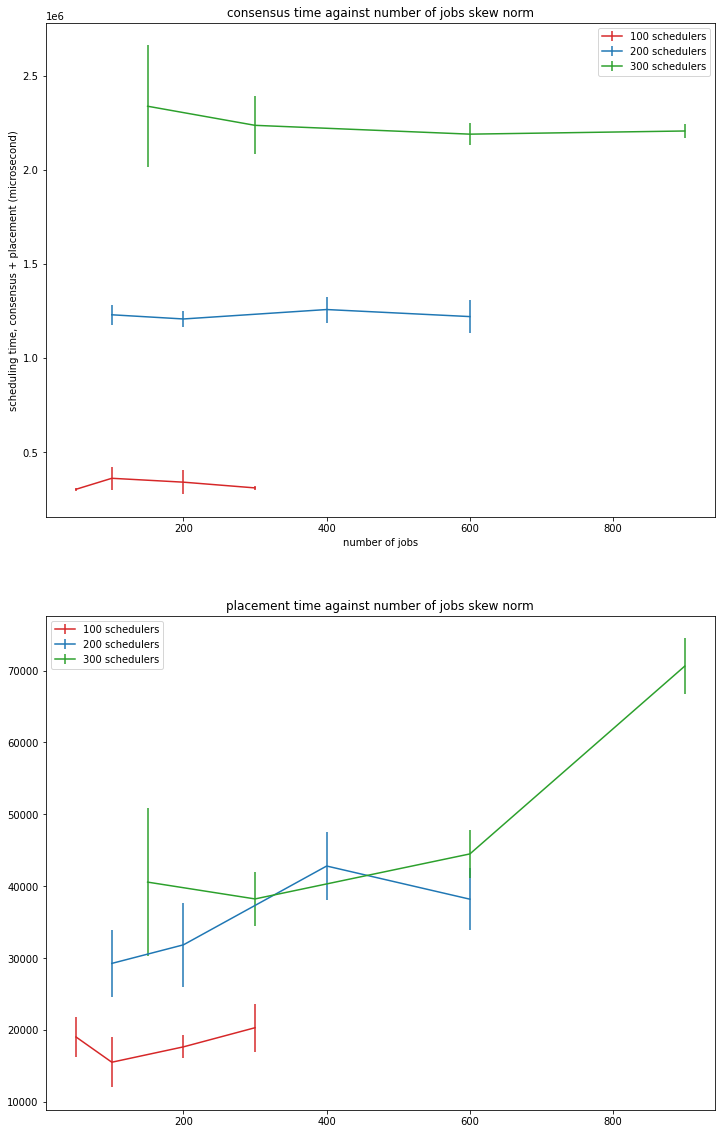

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 20))

for i, p in enumerate(pods):
  ax[0].errorbar(pod_jobs[i], con_pod_times[i][:, 0], yerr = con_pod_times[i][:, 1], label=f'{p} schedulers', color=cs[i])

  ax[1].errorbar(pod_jobs[i], pl_pod_times[i][:, 0], yerr = pl_pod_times[i][:, 1], color=cs[i ], label=f'{p} schedulers')

ax[0].set_title('consensus time against number of jobs skew norm')
ax[1].set_title('placement time against number of jobs skew norm')

ax[0].set_xlabel('number of jobs')
ax[0].set_ylabel('scheduling time, consensus + placement (microsecond)')
ax[0].legend()
ax[1].legend()

fig.savefig(f'{graph_dir}consensus-placement-time-skew-norm.png')

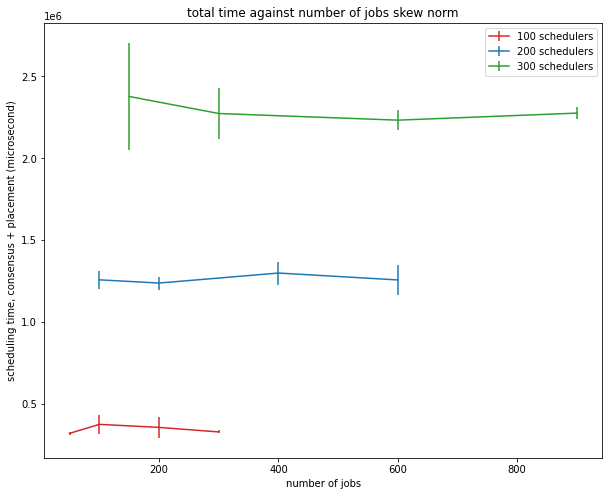

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 12)

for i, p in enumerate(pods):
  ax.errorbar(pod_jobs[i], total_pod_times[i][:, 0], yerr = total_pod_times[i][:, 1], label=f'{p} schedulers', color=cs[i])

ax.set_title('total time against number of jobs skew norm')
ax.set_xlabel('number of jobs')
ax.set_ylabel('scheduling time, consensus + placement (microsecond)')
ax.legend()

fig.set_size_inches(10, 8)

fig.savefig(f'{graph_dir}total-scheduling-time-skew-norm.png')

### different times, log scale

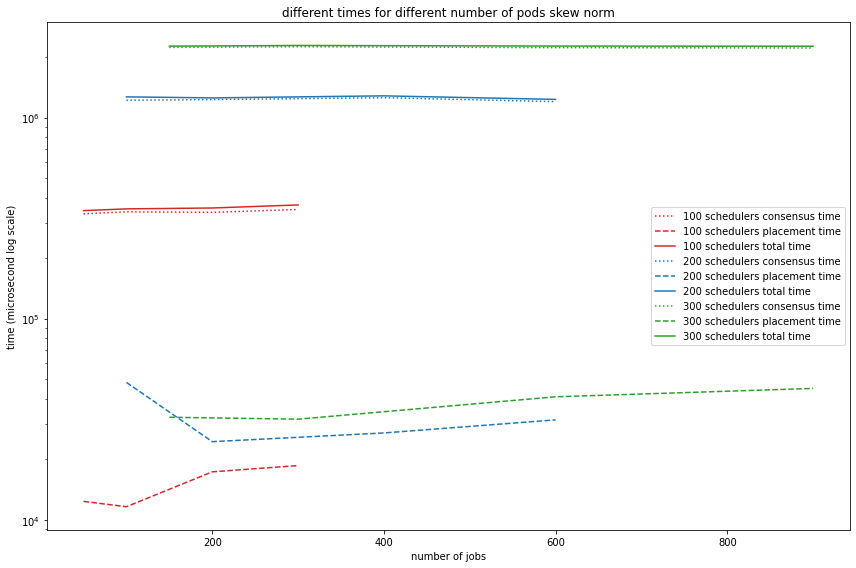

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)



for i, p in enumerate(pods):
  ax.semilogy(pod_jobs[i], con_pod_times[i][:, 0], label=f'{p} schedulers consensus time', ls=':', color = cs[i])
  ax.semilogy(pod_jobs[i], pl_pod_times[i][:,0], label=f'{p} schedulers placement time', ls='--', color = cs[i])
  ax.semilogy(pod_jobs[i], total_pod_times[i][:, 0], label=f'{p} schedulers total time', ls='-', color = cs[i])

ax.set_ylabel('time (microsecond log scale)')
ax.set_xlabel('number of jobs')
ax.set_title(f'different times for different number of pods skew norm')

ax.legend()
fig.tight_layout()

fig.savefig(f'{graph_dir}different-time-against-jobs-log-skew-norm.png')

### scheduled percentage

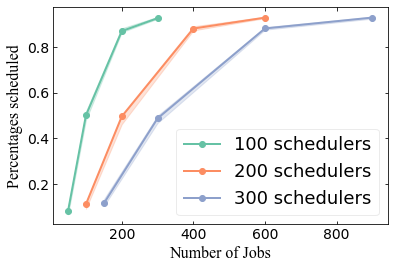

In [4]:
fig, ax = plt.subplots()

for i, p in enumerate(pods):
  ax.plot(pod_jobs[i], sched_pod_pcts[i][:, 0], label=f'{p} schedulers', marker='o', color=cs[i], linewidth=2)
  ax.fill_between(pod_jobs[i], sched_pod_pcts[i][:, 1], sched_pod_pcts[i][:, 2], alpha=0.25, color=cs[i])

# ax.set_title("scheduled percentage skew norm")
ax.set_xlabel("Number of Jobs", fontname='Times New Roman')
ax.set_ylabel("Percentages scheduled", fontname='Times New Roman')

ax.legend(prop=font_manager.FontProperties(family='Times New Roman'))

frame=ax.legend().get_frame()
# frame.set_facecolor('0.9')
frame.set_edgecolor('0.9')

ax.tick_params(axis='both', direction='in')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

fig.savefig(f'{graph_dir}sched-pct-skew-norm.pdf')

# K8S scheduler Comparison

## Junk


In [5]:
default_sched = np.array([
  [245, 583, 905, 1316, 1758, 2174, 2684, 3148, 3734, 4393],
  [247, 541, 948, 1320, 1745, 2245, 2691, 3139, 3719, 4372],
  [243, 541, 929, 1301, 1734, 2159, 2701, 3194, 3754, 4286]
])

my_sched = np.array([
  [219, 444, 667, 906, 1137, 1366, 1578, 1793, 2065, 2271],
  [219, 460, 675, 907, 1134, 1345, 1572, 1603, 2039, 2296],
  [218, 454, 672, 902, 1129, 1359, 1585, 1804, 1874, 1840]
])

default_sched_avg = np.array([[np.mean(default_sched[:, i]), np.std(default_sched[:, i])] for i in range(len(default_sched[0]))])
my_sched_avg = np.array([[np.mean(my_sched[:, i]), np.std(my_sched[:, i])] for i in range(len(my_sched[0]))])
print(default_sched_avg[:, 1])
print(my_sched_avg[:, 1])

[ 1.63299316 19.79898987 17.59419096  8.17856276  9.80929265 37.50851755
  6.97614985 24.08780235 14.33720878 46.29134788]
[  0.47140452   6.59966329   3.29983165   2.1602469    3.29983165
   8.7305339    5.31245915  92.26893061  84.57869445 209.31687833]


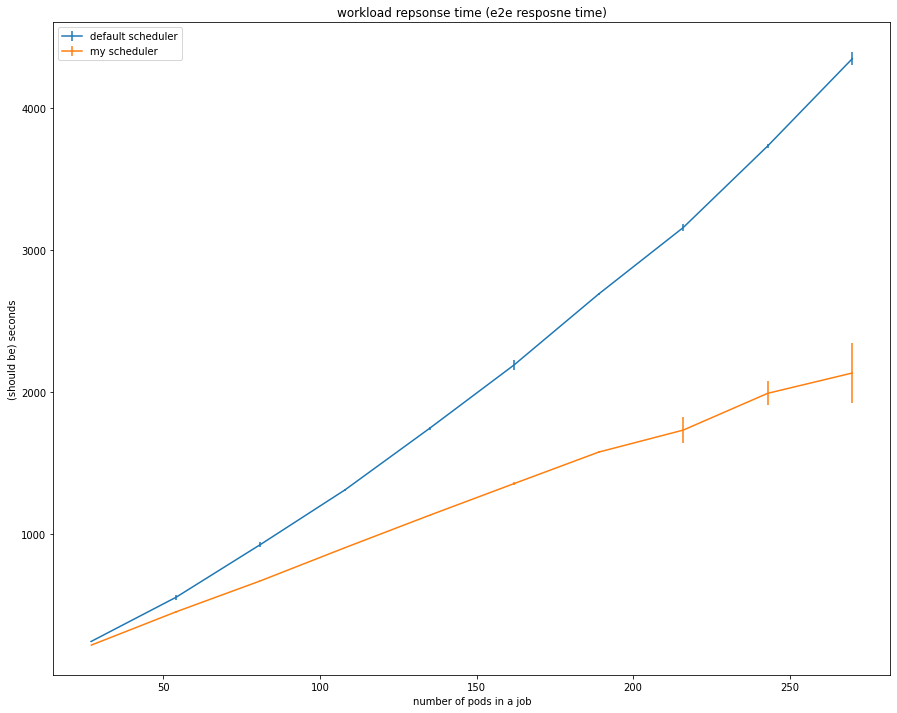

In [15]:
x = range(27, 11*27, 27)

fig, ax = plt.subplots()
fig.set_size_inches(15, 12)

ax.errorbar(x, default_sched_avg[:, 0], yerr=default_sched_avg[:, 1], label='default scheduler')
ax.errorbar(x, my_sched_avg[:, 0], yerr=my_sched_avg[:, 1],  label='my scheduler')

ax.set_xlabel('number of pods in a job')
ax.set_ylabel('(should be) seconds')
ax.set_title('workload repsonse time (e2e resposne time)')
ax.legend()

fig.savefig(f'{graph_dir}compare_sched_3run.pdf')


## Useful

### consensus vs algorithm

In [3]:
# dir = 'data/2022-09-09T14-06-05'

# -------- 1-10 * 36 jobs ---------- #
dir = 'data/2022-09-09T19-50-33' 

# ---variance finding --- #
# dir = 'data/2022-09-16T19-52-44'
# dir = 'data/2022-09-16T20-46-36'
# dir = 'data/2022-09-16T22-14-53'
dir = 'data/2022-09-18T01-21-38'

# -------- 10-20 * 36 jobs --------- #
# dir = 'data/2022-09-16T15-42-38'
# dirs= [
dir = 'data/2022-09-16T13-18-46'
dir = 'data/2022-09-21T01-52-31'
# ]

# ------ 1-20 * 36 jobs ----------- #
dir = 'data/2022-09-21T08-48-55'
dir = 'data/2022-09-22T09-36-28'

# default_scheduleing_algorithm_duration = 
# default_scheduling_e2e_time = 

default_scheduling_algorithm_duration = np.array([
  [0.0279,0.0486,0.0648,0.0768,0.0976,0.166,0.186,0.223,0.217,0.249,0.275,0.291,0.318,0.337,0.348,0.402,0.422,0.446,0.461],
  [0.0248,0.0474,0.0870,0.113,0.135,0.169,0.200,0.216,0.218,0.244,0.280,0.307,0.327,0.368,0.381,0.414,0.432,0.440,0.454],
  [0.0237,0.0499,0.0848,0.120,0.122,0.157,0.183,0.216,0.236,0.269,0.280,0.290,0.340,0.362,0.384,0.413,0.446,0.452,0.466]
])

default_scheduling_e2e_time = np.array([
  [1.69,3.59,4.76,6.79,8.34,10.02,11.7,13.7,14.5,16.2,18.5,20.7,21.4,23.8,25.0,27.9,29.0,31.3,33.8],
  [1.47,3.05,4.86,6.51,7.31,9.15,11.8,14.0,15.2,16.2,18.2,20.7,23.2,24.8,25.4,26.6,30.5,33.3,33.1],
  [1.33,3.17,4.47,6.87,8.50,9.98,11.8,13.4,15.5,16.4,19.0,19.8,21.3,23.8,29.1,27.3,28.5,31.3,34.2],
])



job_factors = range(1, 20)

multi_con_times = []
multi_pl_times = []

con_times = []
pl_times = []

with open(f'{dir}/consensus-9pods-4.0jobs.json') as f:
  con_data = json.load(f)

with open(f'{dir}/placement-9pods-4.0jobs.json') as f:
  pl_data = json.load(f)

for trial in range(5):
  con_time = []
  pl_time = []
  for i in job_factors:
    s = sum(range(job_factors[0], i)) + trial * sum(job_factors)
    print(s, s + i )

    con_ts = 0
    pl_ts = 0

    for j in range(s, s + i ):
      sched_data = con_data[str(j)]
      ctl_data = pl_data[str(j)]

      t = []
      for k, v in sched_data.items():
        t.append(v['total time'])
        if j == 117:
          print(f"j = {j} {v['total time']}")
      print(int(np.mean(np.array(t))), end=',')
      con_ts += np.mean(np.array(t))

      for k in ctl_data:
        if k.startswith('my-controller'):
          pl_ts += ctl_data[k]['time taken']
    print()
    print(f"sum is {con_ts}")
    con_time.append(con_ts)
    pl_time.append(pl_ts)

  con_times.append(con_time)
  pl_times.append(pl_time)


con_times = np.array(con_times)
pl_times = np.array(pl_times)


0 1
14258,
sum is 14258.666666666666
1 3
12597,47577,
sum is 60175.44444444444
3 6
11632,10698,11780,
sum is 34111.555555555555
6 10
12274,10775,32236,10150,
sum is 65436.333333333336
10 15
12895,12082,15382,9915,10723,
sum is 61000.33333333334
15 21
13790,10437,12836,8136,8700,10360,
sum is 64260.666666666664
21 28
12910,14779,36279,13786,9535,10392,11687,
sum is 109371.55555555556
28 36
12270,10127,13249,10755,10398,12831,11107,12378,
sum is 93118.44444444444
36 45
11936,10321,12481,9171,9922,32872,11134,12040,10450,
sum is 120331.88888888889
45 55
13594,10442,15858,11774,9929,12390,11130,12123,9608,10418,
sum is 117270.22222222222
55 66
11572,9312,10778,10182,10677,9913,11530,13764,14635,14021,19890,
sum is 136279.11111111112
66 78
12594,10007,14188,9904,9314,11045,12757,14551,9296,12729,10607,13589,
sum is 140587.22222222225
78 91
11967,13110,12575,10483,9784,12212,11361,13180,12451,17410,10209,13221,18423,
sum is 166393.22222222222
91 105
12377,11054,12408,12171,11690,9561,15014,1

In [4]:
con_times = con_times / 1000
pl_times = pl_times / 1000
default_scheduling_algorithm_duration = default_scheduling_algorithm_duration * 1000
default_scheduling_e2e_time = default_scheduling_e2e_time * 1000

default_con_time = []
my_con_time = []
my_e2e_time = []
default_e2e_time = []

for i in range(len(pl_times[0])):
  x= default_scheduling_algorithm_duration[:, i]
  default_con_time.append([np.median(x), np.percentile(x, 25), np.percentile(x, 75)])

  x = con_times[:, i]
  my_con_time.append([np.median(x), np.percentile(x,25), np.percentile(x, 75)])

  x = default_scheduling_e2e_time[:, i]
  default_e2e_time.append([np.median(x), np.percentile(x, 25), np.percentile(x, 75)])

  x = pl_times[:, i] + con_times[:, i]
  my_e2e_time.append([np.median(x), np.percentile(x, 25), np.percentile(x, 75)])

default_con_time = np.array(default_con_time)
default_e2e_time = np.array(default_e2e_time) / 1000
my_con_time = np.array(my_con_time)
my_e2e_time = np.array(my_e2e_time) / 1000


# print(default_con_time)
print(my_con_time)
# print(default_e2e_time)
# print(my_e2e_time)

[[ 13.58177778  12.66622222  14.25866667]
 [ 27.29211111  24.42466667  30.48677778]
 [ 36.506       36.45677778  38.97088889]
 [ 49.67766667  49.087       60.51888889]
 [ 61.00033333  60.56922222  61.26433333]
 [ 82.69688889  74.65722222  83.07033333]
 [ 85.86988889  83.56922222  91.37088889]
 [ 93.19455556  93.11844444  96.91222222]
 [114.83677778 109.82755556 120.33188889]
 [117.53488889 117.27022222 151.77933333]
 [131.53644444 129.00322222 136.27911111]
 [140.58722222 135.88666667 142.38188889]
 [166.39322222 162.83355556 171.36044444]
 [171.203      155.96022222 172.09677778]
 [181.03222222 177.33733333 217.73711111]
 [232.17888889 203.38244444 247.885     ]
 [211.287      200.50355556 218.55122222]
 [244.06122222 236.69166667 263.047     ]
 [260.03855556 241.35088889 268.82922222]]


[ 36  72 108 144 180 216 252 288 324 360 396 432 468 504 540 576 612 648
 684] [0, 100, 200, 300, 400, 500, 600, 700]


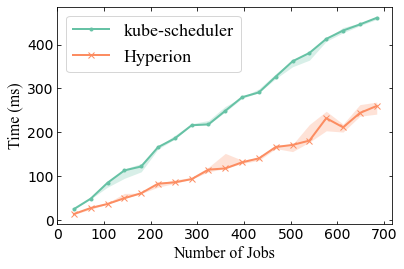

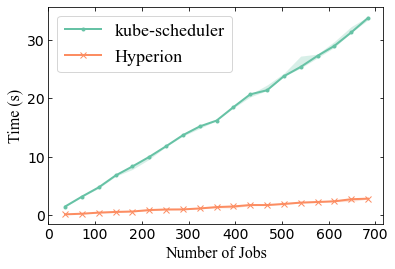

In [8]:
x = np.array(job_factors) * 36
xticks = range(0, (max(x) // 100+ 2) * 100, 100)
print(x, list(xticks))

fig, ax = plt.subplots()

ax.plot(x, default_con_time[:, 0], marker='.', linewidth=2, label='kube-scheduler', color=cs[0])
ax.plot(x, my_con_time[:, 0], marker='x', linewidth=2, label='Hyperion', color=cs[1])
ax.fill_between(x,  default_con_time[:, 1], default_con_time[:, 2], linewidth=0, color=cs[0], alpha=0.25)
ax.fill_between(x,  my_con_time[:, 1], my_con_time[:, 2], linewidth=0, color=cs[1], alpha=0.25)
frame=ax.legend().get_frame()
# frame.set_facecolor('0.9')
frame.set_edgecolor('0.9')
ax.legend(prop=font_manager.FontProperties(family='Times New Roman', size=18))
ax.set_xticks(xticks)
ax.tick_params(axis='both', direction='in')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
# ax.set_title('nine nodes/schedulers 36 jobs each batch, scheduling algorithm duration')
ax.set_ylabel('Time (ms)', fontname='Times New Roman')
ax.set_xlabel('Number of Jobs', fontname='Times New Roman')

fig.savefig(f'{graph_dir}con_time_and_algo_duration.pdf')


fig, ax = plt.subplots()
ax.plot(x, default_e2e_time[:, 0], marker='.', linewidth=2, label='kube-scheduler', color=cs[0])
ax.plot(x, my_e2e_time[:,0], marker='x', linewidth=2, label='Hyperion', color=cs[1])

ax.fill_between(x,  default_e2e_time[:, 1], default_e2e_time[:, 2], linewidth=0, color=cs[0], alpha=0.25)
ax.fill_between(x,  my_e2e_time[:, 1], my_e2e_time[:, 2], linewidth=0, color=cs[1], alpha=0.25)
ax.legend()
frame=ax.legend().get_frame()
frame.set_facecolor('0.9')
ax.set_xticks(xticks)
ax.tick_params(axis='both', direction='in')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Time (s)', fontname='Times New Roman')
ax.set_xlabel('Number of Jobs', fontname='Times New Roman')
# ax.set_title('scheduling e2e duration')

ax.legend(prop=font_manager.FontProperties(family='Times New Roman', size=18))


fig.savefig(f'{graph_dir}sched_e2e_time.pdf')

### balance

In [9]:
# ------- pi -------- #
# dist_pi = np.array([
#   [0.292,0.272,0.267,0.262,0.215,0.200,0.196,0.192,0.184],
#   [0.317,0.294,0.290,0.224,0.217,0.216,0.209,0.198,0.136]
# ])

# default_pi = np.array([
#   [0.306,0.283,0.282,0.278,0.205,0.204,0.198,0.180,0.0170],
#   [0.310,0.269,0.252,0.243,0.240,0.238,0.210,0.190,0.0150],
# ])

# ----- containerd ---- #

dist_pi = np.array([
  [0.301,0.272,0.270,0.258,0.235,0.197,0.193,0.183,0.162],
  [0.297,0.280,0.256,0.206,0.206,0.197,0.192,0.191,0.182],
  [0.281,0.267,0.259,0.253,0.206,0.201,0.196,0.176,0.173]
])


default_pi = np.array([
  [0.279,0.272,0.268,0.258,0.258,0.185,0.149,0.138,0.124],
  [0.278,0.262,0.259,0.254,0.242,0.203,0.156,0.146,0.123],
  [0.301,0.270,0.259,0.254,0.253,0.220,0.187,0.160,0.116]
])

# ------ fib -------- #

dist_fib = np.array([
  [0.265,0.245,0.216,0.177,0.174,0.160,0.158,0.157,0.108],
  [0.235,0.223,0.211,0.200,0.180,0.175,0.159,0.153,0.150],
  [0.221,0.221,0.221,0.219,0.182,0.161,0.154,0.151,0.134]
])

default_fib = np.array([
  [0.271,0.246,0.215,0.201,0.199,0.187,0.157,0.127,0.110],
  [0.252,0.228,0.219,0.214,0.203,0.176,0.129,0.113,0.0953],
  [0.268,0.219,0.209,0.206,0.202,0.201,0.136,0.122,0.0864]
])


# ------ fft ------- $

dist_fft = np.array([
  # [0.629,0.500,0.486,0.441,0.418,0.339,0.312,0.312,0.214],
  # [0.608,0.577,0.566,0.517,0.357,0.286,0.286,0.261,0.257],
  # [0.568,0.565,0.499,0.483,0.430,0.340,0.296,0.275,0.146],
  [0.439,0.437,0.389,0.368,0.264,0.231,0.225,0.211,0.193],
  [0.414,0.377,0.375,0.373,0.296,0.252,0.247,0.232,0.209],
  [0.451,0.426,0.420,0.395,0.243,0.222,0.203,0.200,0.172]

])

default_fft = np.array([
  # [0.620,0.529,0.499,0.408,0.369,0.285,0.261,0.252,0.241]
  [0.453,0.430,0.383,0.335,0.327,0.290,0.256,0.252,0.0726],
  [0.385,0.364,0.360,0.357,0.330,0.304,0.274,0.215,0.154],
  [0.446,0.388,0.382,0.344,0.293,0.245,0.242,0.215,0.139]
])

In [10]:
dist_std = np.array([np.std(x, axis = 1) for x in [dist_pi, dist_fib, dist_fft]])
dist_means = np.array([np.mean(x) for x in dist_std])
dist_means = np.array([round(x, 3) for x in dist_means])
default_std = np.array([np.std(x, axis = 1) for x in [default_pi, default_fib, default_fft]])
default_means = np.array([np.mean(x) for x in default_std])
default_means = np.array([round(x, 3) for x in default_means])

print(dist_means, default_means)

dist_err = [np.std(x) for x in dist_std]
default_err = [np.std(x) for x in default_std]




[0.042 0.037 0.092] [0.057 0.052 0.091]


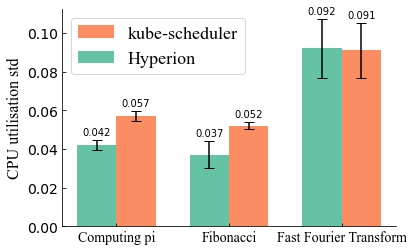

In [11]:
fig, ax = plt.subplots()

labels = ['Computing pi', 'Fibonacci', 'Fast Fourier Transform']

x = np.arange(len(labels))
width = 0.35  # the width of the bars



rects2 = ax.bar(x + width / 2, default_means, yerr = default_err, width = width, label='kube-scheduler', color=cs[1], capstyle='projecting', capsize=5)
rects1 = ax.bar(x - width / 2, dist_means, yerr = dist_err, width=width, label='Hyperion', color=cs[0], capstyle='projecting', capsize=5)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.set_ylabel('std')
# ax.set_title('cpu utilisation std')
ax.set_xticks(x, labels, fontname='Times New Roman')

frame=ax.legend().get_frame()
# frame.set_facecolor('0.9')
frame.set_edgecolor('0.9')
ax.legend(prop={'family':'Times New Roman'})
ax.tick_params(axis='both', direction='in')
# ax.xaxis.set_ticks_position('both')
# ax.yaxis.set_ticks_position('both')
ax.set_ylabel('CPU utilisation std', fontname='Times New Roman')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlabel('Workload', fontname='Times New Roman')
# ax.set_title('scheduling e2e duration')

fig.savefig(f'{graph_dir}cpu_util_std.pdf')


### Pod execution time


In [4]:
default_pi = np.array([74,76,72,69,76])
dist_pi = np.array([67,78,75,69,79])

default_fib = np.array([68,66,66,66,69])
dist_fib = np.array([70,74,76,73,71])


default_fft = np.array([106,112,89,108,111])
dist_fft = np.array([87,105,109,80,125])


default_means = np.array([np.mean(x) for x in [default_pi, default_fib, default_fft]])
default_err = [np.std(x) for x in [default_pi, default_fib, default_fft]]
dist_means = np.array([np.mean(x) for x in [dist_pi, dist_fib, dist_fft]])
dist_err = [np.std(x) for x in [dist_pi, dist_fib, dist_fft]]

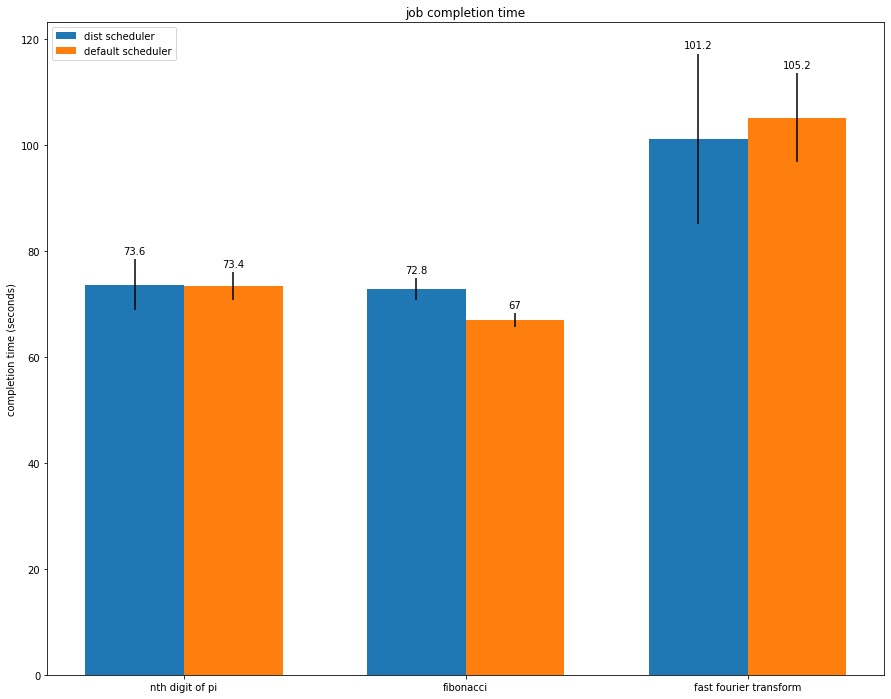

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 12)

labels = ['nth digit of pi', 'fibonacci', 'fast fourier transform']

x = np.arange(len(labels))
width = 0.35  # the width of the bars



rects1 = ax.bar(x - width / 2, dist_means, yerr = dist_err, width=width, label='dist scheduler')
rects2 = ax.bar(x + width / 2, default_means, yerr = default_err, width = width, label='default scheduler')

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.set_ylabel('completion time (seconds)')
ax.set_title('job completion time')
ax.set_xticks(x, labels)

ax.legend(loc='upper left')

fig.savefig(f'{graph_dir}job_completion.png')
